In [1]:
from pyautofit.model import AutoFitModel
from pyautofit.config import AutoFitConfig
from pyautofit.data import AutoFitDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd

In [6]:
pd.read_csv('demo.csv').head()

,index,feat_1,feat_2,feat_3,feat_4,feat_5,gbf,weight,feat_cat
0,0,0.0,0.0,2.777778,0.0,0.967762,1,4,c
1,1,0.0,0.0,6.000000,0.0,0.980904,1,9,a
2,2,0.0,0.0,4.000000,0.0,1.139252,0,2,a
3,3,0.0,0.0,4.555556,0.0,1.065789,1,9,b
4,4,1.0,4.0,0.000000,8.0,1.261156,1,8,d


In [2]:
# xgboost config
xgboost_config = AutoFitConfig.from_json('configs/xgboost_config.json')
# lightgbm config
lightgbm_config = AutoFitConfig.from_json('configs/lightgbm_config.json')

In [3]:
# inspect
print('xgboost config: \n'+str(xgboost_config.to_dict()))
print('lightgbm config: \n'+str(lightgbm_config.to_dict()))

xgboost config: 
{'name': 'autofit_config', 'version': 'template', 'classifier_config': {'model': 'xgboost', 'params': {'max_depth': 1, 'n_estimators': 600, 'learning_rate': 0.05, 'objective': 'binary:logistic', 'booster': 'gbtree', 'n_jobs': 1, 'eval_metric': 'auc', 'early_stopping_rounds': 50}, 'random_state': 2333}, 'dataset_config': {'id_col': 'applicationid', 'flag_col': 'xy_gbf'}, 'binning_config': {'method': 'num_bads', 'max_bins': 50, 'min_bads': 10}}
lightgbm config: 
{'name': 'autofit_config', 'version': 'template', 'classifier_config': {'model': 'lightgbm', 'params': {'boost_type': 'gbdt', 'num_leaves': 3, 'max_depth': 1, 'n_estimators': 2500, 'learning_rate': 0.05, 'objective': 'binary:logistic', 'booster': 'gbtree', 'n_jobs': 1, 'eval_metric': 'auc', 'early_stopping_rounds': 50}, 'random_state': 2333}, 'dataset_config': {'id_col': 'applicationid', 'flag_col': 'xy_gbf'}, 'binning_config': {'method': 'num_bads', 'max_bins': 50, 'min_bads': 10}}


In [7]:
# Override configurations
lightgbm_config.dataset_config = dict(id_col='index', flag_col='gbf', instance_weight_col='weight', categorical_cols=['feat_cat'])

NameError: name 'config' is not defined

In [ ]:
config.to_dict()

In [6]:
# Save new config to json
config.to_json('configs/new.json')

In [7]:
# Construct dataset object
af_ds = AutoFitDataset.from_csv(file_path='demo.csv', config=config.dataset_config)

In [8]:
# Construct a model object
model = AutoFitModel(name='test_model', config=config, version='version_0')

In [9]:
# Feature binning
model.auto_binning(af_ds=af_ds, binning_config=config.binning_config)

ERROR:root:Feature: qantas dropped because only 1 valid bin found!
C:\Users\bxh150\Documents\Git\pyautofit\pyautofit\utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  result = np.log(g_pct/b_pct)
ERROR:root:Feature: medibank dropped because only 1 valid bin found!
ERROR:root:Feature: pay_salary dropped because only 1 valid bin found!
C:\Users\bxh150\Documents\Git\pyautofit\pyautofit\utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  result = np.log(g_pct/b_pct)
ERROR:root:Feature: credit_adjustment dropped because only 1 valid bin found!
ERROR:root:Feature: uni_university dropped because only 1 valid bin found!


In [ ]:
# Full pipeline example
# Feature binning -> apply monotone constraint -> train a xgboost model 
model.modeling_xgboost(af_ds=af_ds, apply_binning=True, correlation_threshold=.3, test_size=.2)

In [11]:
# Inspect binned features
feats = model.features_to_csv()

In [12]:
feats.head()

,bins,points,bads,goods,counts,counts_pct,woe,iv,feature
0,"(-inf, 1.0]",None,1904,9368,11272,0.112722,0.071930,0.0061,tax
1,"(1.0, 2.0]",None,683,3184,3867,0.038671,0.017986,0.0061,tax
2,"(2.0, 3.0]",None,673,3183,3856,0.038561,0.032421,0.0061,tax
3,"(3.0, 4.0]",None,583,2628,3211,0.032111,-0.015622,0.0061,tax
4,"(4.0, 5.0]",None,429,2162,2591,0.025911,0.095919,0.0061,tax


In [13]:
# Get points for each bin and add intercept 
ca = model.character_analysis()

C:\Users\bxh150\Documents\Git\pyautofit\pyautofit\utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  result = np.log(g_pct/b_pct)
C:\Users\bxh150\Documents\Git\pyautofit\pyautofit\utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  result = np.log(g_pct/b_pct)


In [14]:
ca.head()

,bins,points,bads,goods,counts,counts_pct,woe,iv,feature
0,NaN,0.820750,NaN,NaN,NaN,NaN,NaN,NaN,intercept
1,"(21.0, 1272.0]",-0.024573,7203.0,30701.0,37904.0,0.379048,-0.071615,0.003611,tax
2,"(17.0, 21.0]",-0.002200,1289.0,5809.0,7098.0,0.070981,-0.015871,0.003611,tax
3,"(-inf, 6.0]",0.016123,4795.0,22924.0,27719.0,0.277196,0.043198,0.003611,tax
4,"(6.0, 17.0]",0.019518,4638.0,22639.0,27277.0,0.272775,0.063978,0.003611,tax


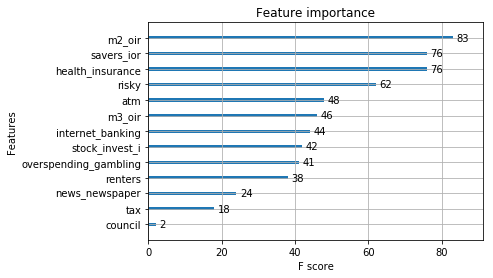

In [15]:
model.plot_feature_importance()

In [16]:
# Inference on a new dataset
val_df = af_ds.df.iloc[:1000]

In [17]:
help(AutoFitDataset)

Help on class AutoFitDataset in module pyautofit.data:

class AutoFitDataset(builtins.object)
 |  AutoFitDataset(df, id_col='idx', flag_col='gbf', flag_weight=None, instance_weight_col=None, exclusions=None)
 |  
 |  Constructs dataset for autofit
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df, id_col='idx', flag_col='gbf', flag_weight=None, instance_weight_col=None, exclusions=None)
 |      Constructs AutoFit Dataset
 |      Args:
 |          df: a pandas DataFrame
 |          id_col: id column name
 |          flag_col: flag column name, value should only have 1 and 0, where 1 for good and 0 for bad
 |          flag_weight(Optional): a dictionary contains {'G': g_weight, 'B': b_weight}
 |          instance_weight_col(Optional): weight column for each record
 |          exclusions(Optional): a list contains columns not used in model
 |      
 |      Return:
 |          an AutoFitDataset instance
 |  
 |  get_feat_df(self)
 |  
 |  -------------------------------------------

In [18]:
val_afds = AutoFitDataset(val_df, id_col='applicationid', flag_col='xy_gbf')

In [19]:
# Apply inference on 
model.inference(val_afds)

0.14171525296219656